# Importing the right libraries


In [42]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utility.utils import compute_trend_target_on_dataframe
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from neural_networks.rbf_layer import RBFLayer, InitCentersRandom
from utility.stats import check_stationarity

# Load the data (once)

## Reading the files


In [107]:
df = pd.read_excel(
    "../data/APPLE.xlsx", sheet_name="Feuil1", names=["date", "prices"], skiprows=0
).iloc[-4000:]

df["returns"] = df["prices"].pct_change()
df["returns_1H"] = df["prices"].pct_change(60)
df["returns_2H"] = df["prices"].pct_change(60 * 2)
df["returns_5H"] = df["prices"].pct_change(60 * 5)
df["returns_24H"] = df["prices"].pct_change(60 * 24)
df["EMA_returns_24H"] = df["returns_24H"].ewm(span=100).mean()
df["returns_48H"] = df["prices"].pct_change(60 * 24 * 2)
# df["variance"] = df["returns"].rolling(100).var()

df["vol"] = (
    df["returns"].rolling(100).std().apply(lambda x: x * np.sqrt(252 * 60 * 6.5))
)
# df["volvol"] = df["vol"].rolling(100).std()
df['backward_linear_reg_1H'] = df['prices'].rolling(60).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
df['backward_linear_reg_2H'] = df['prices'].rolling(60*2).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
df['backward_linear_reg_5H'] = df['prices'].rolling(60*5).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
df['backward_linear_reg_24H'] = df['prices'].rolling(60*24).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])

df = df.dropna().reset_index(drop=True)
print(df.shape)
df.head()

(1120, 14)


,date,prices,returns,returns_1H,returns_2H,returns_5H,returns_24H,EMA_returns_24H,returns_48H,vol,backward_linear_reg_1H,backward_linear_reg_2H,backward_linear_reg_5H,backward_linear_reg_24H
0,2023-12-28 21:09:00,193.95,0.000052,-0.000258,0.000413,0.000206,0.005287,0.005271,-0.005996,0.055073,-0.002432,0.002209,-0.001051,0.001303
1,2023-12-28 21:10:00,193.91,-0.000206,-0.000515,0.000103,-0.000361,0.005080,0.005267,-0.006099,0.055382,-0.002541,0.002198,-0.001063,0.001304
2,2023-12-28 21:11:00,193.91,0.000000,-0.000721,0.000206,-0.000258,0.005132,0.005265,-0.006099,0.055382,-0.002577,0.002178,-0.001076,0.001305
3,2023-12-28 21:12:00,193.88,-0.000155,-0.000979,0.000155,-0.000103,0.004976,0.005259,-0.006253,0.053270,-0.002620,0.002137,-0.001095,0.001306
4,2023-12-28 21:13:00,193.83,-0.000258,-0.001185,-0.000103,-0.000361,0.004665,0.005247,-0.006509,0.053882,-0.002751,0.002074,-0.001117,0.001307


## Adding the target (predict the next couple of hour trend)

The next couple of hour trend is refered as the target variable. The target variable the coefficient from the forward looking linear regression.


In [108]:
df = compute_trend_target_on_dataframe(
    df,
    original_feature="prices",
    forward_window=60 * 2,
    target_name="target",
    regression_type="linear",
)
df.head()

Calculating targets:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating targets: 100%|██████████| 1000/1000 [00:00<00:00, 1170.35it/s]


,date,prices,returns,returns_1H,returns_2H,returns_5H,returns_24H,EMA_returns_24H,returns_48H,vol,backward_linear_reg_1H,backward_linear_reg_2H,backward_linear_reg_5H,backward_linear_reg_24H,target
0,2023-12-28 21:09:00,193.95,0.000052,-0.000258,0.000413,0.000206,0.005287,0.005271,-0.005996,0.055073,-0.002432,0.002209,-0.001051,0.001303,0.000333
1,2023-12-28 21:10:00,193.91,-0.000206,-0.000515,0.000103,-0.000361,0.005080,0.005267,-0.006099,0.055382,-0.002541,0.002198,-0.001063,0.001304,0.000427
2,2023-12-28 21:11:00,193.91,0.000000,-0.000721,0.000206,-0.000258,0.005132,0.005265,-0.006099,0.055382,-0.002577,0.002178,-0.001076,0.001305,0.000511
3,2023-12-28 21:12:00,193.88,-0.000155,-0.000979,0.000155,-0.000103,0.004976,0.005259,-0.006253,0.053270,-0.002620,0.002137,-0.001095,0.001306,0.000600
4,2023-12-28 21:13:00,193.83,-0.000258,-0.001185,-0.000103,-0.000361,0.004665,0.005247,-0.006509,0.053882,-0.002751,0.002074,-0.001117,0.001307,0.000668


Text(0.5, 1.0, 'Zoom - Stock Price and Target')

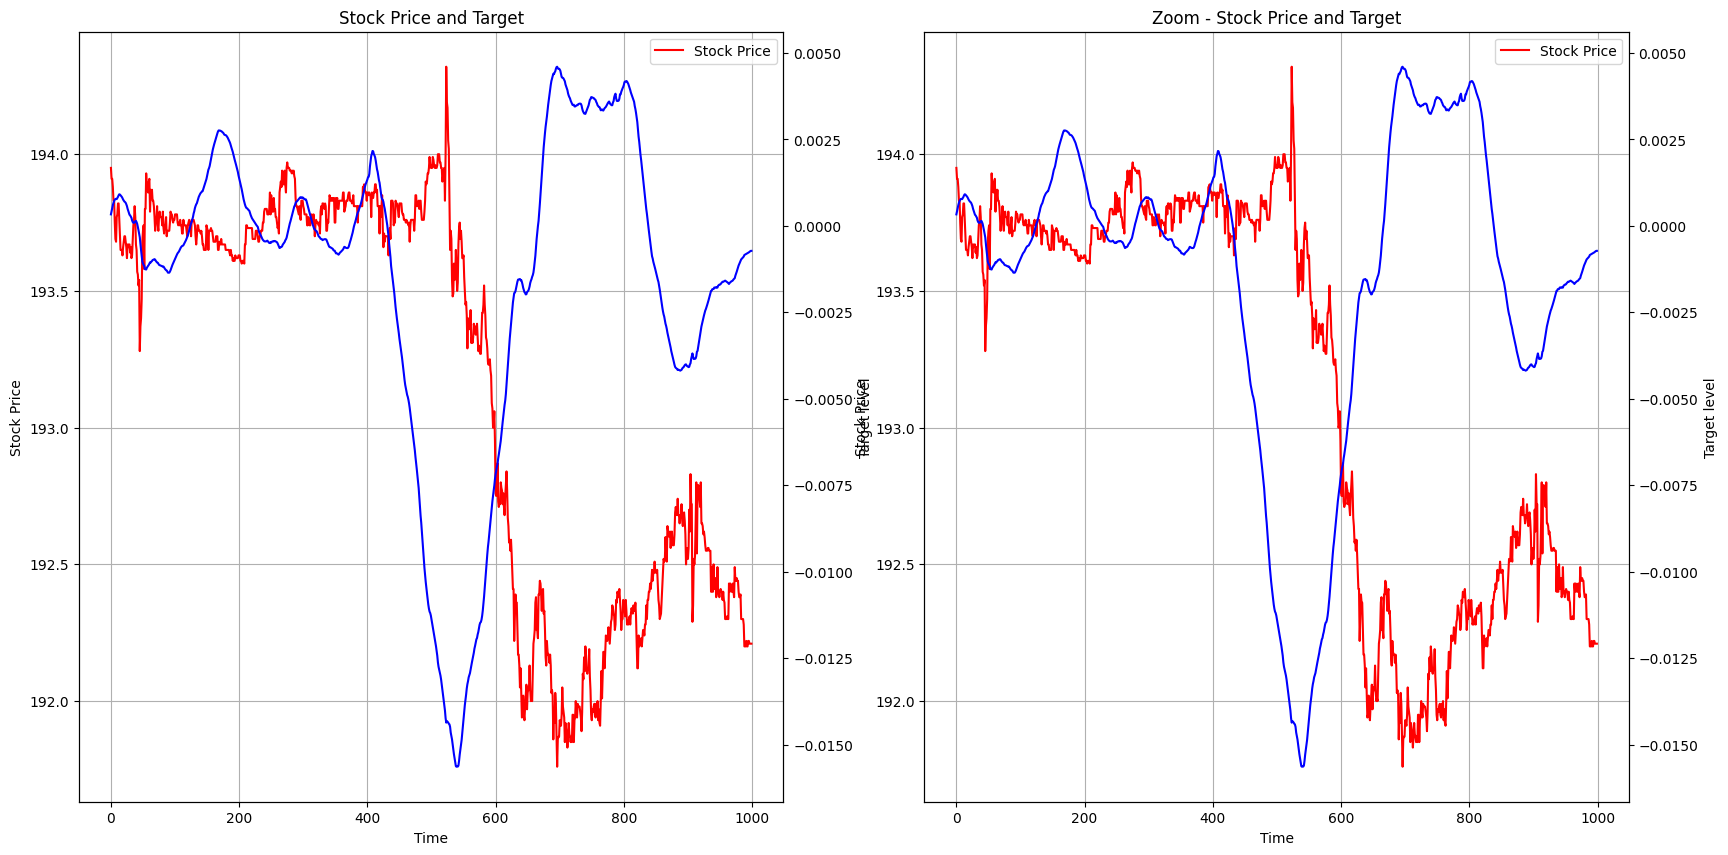

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(df.prices, color="red", label="Stock Price")
axl = ax[0].twinx()
axl.plot(df.target, color="blue", label="Target")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()
ax[0].set_title("Stock Price and Target")

ax[1].plot(df.prices.iloc[-1000:], color="red", label="Stock Price")
axl = ax[1].twinx()
axl.plot(df.target.iloc[-1000:], color="blue", label="Target")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Stock Price")
ax[1].legend()
ax[1].grid()
ax[1].set_title("Zoom - Stock Price and Target")

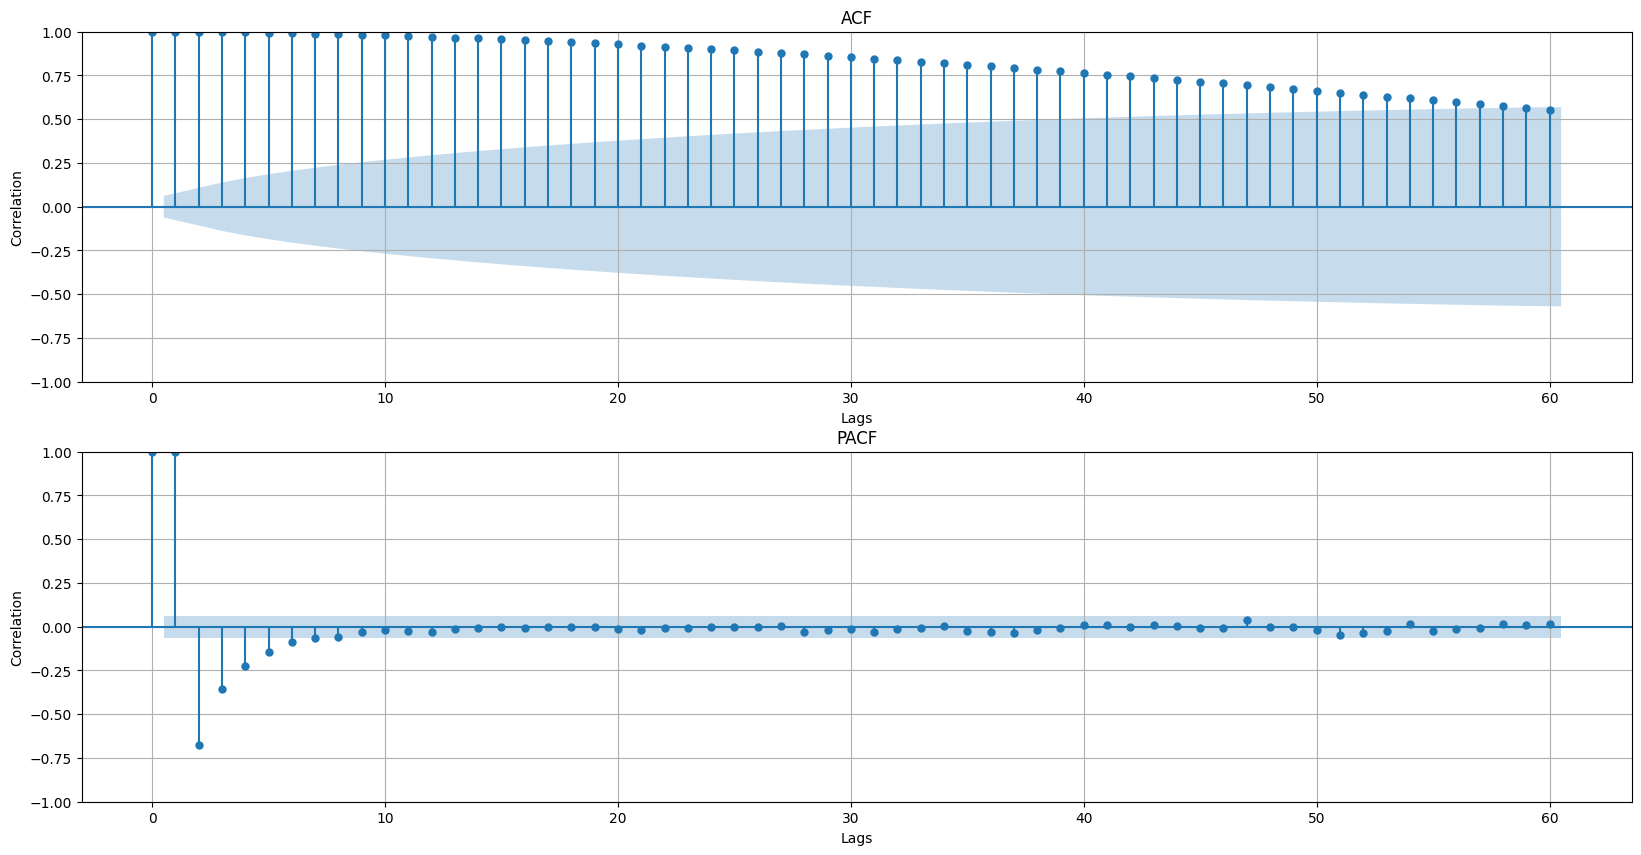

In [110]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plot_acf(df.target, lags=60, ax=ax[0])
plot_pacf(df.target, lags=60, ax=ax[1])


ax[0].set_title("ACF")
ax[1].set_title("PACF")
ax[0].set_xlabel("Lags")
ax[1].set_xlabel("Lags")
ax[0].set_ylabel("Correlation")
ax[1].set_ylabel("Correlation")
ax[0].grid()
ax[1].grid()

plt.show()
# check_stationarity(df.target)

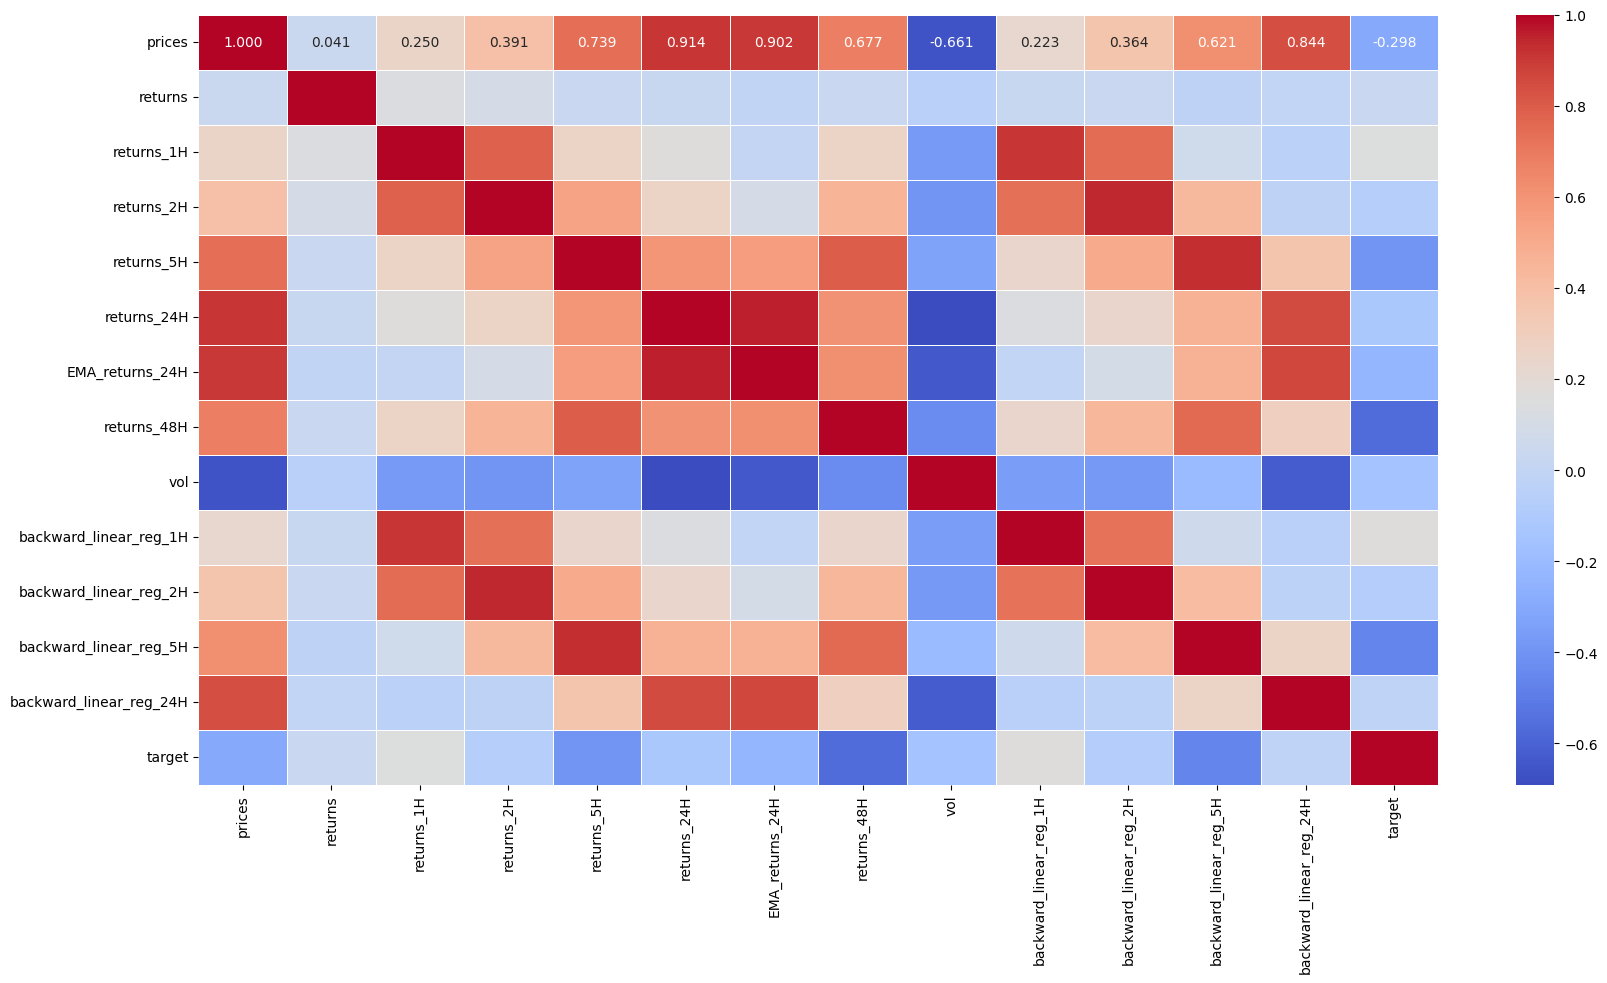

In [111]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(df.corr(), cmap="coolwarm", fmt=".3f", linewidths=0.5, annot=True)

plt.show()

## Creating train and test data sets


In [112]:
X = df.drop(columns=["target", "date"]).to_numpy()
Y = df["target"].to_numpy().reshape(-1, 1)

TEST_PERCENT = 0.15
TRAIN_PERCENT = 1 - TEST_PERCENT

X_train = X[: int(X.shape[0] * TRAIN_PERCENT)]
X_test = X[int(X.shape[0] * TRAIN_PERCENT) :]
Y_train = Y[: int(Y.shape[0] * TRAIN_PERCENT)]
Y_test = Y[int(Y.shape[0] * TRAIN_PERCENT) :]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((850, 13), (150, 13), (850, 1), (150, 1))

## Scaling/normilizing the data


In [113]:
X_train_scaler = RobustScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)

X_test_scaler = RobustScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

Y_train_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_train_scaled = Y_train_scaler.fit_transform(Y_train)

Y_test_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_test_scaled = Y_test_scaler.fit_transform(Y_test)

X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((850, 13), (150, 13), (850, 1), (150, 1))

## Reducing the dimension of X with PCA
This step is not necessary but it is a good practice to reduce the dimension of the data. It will help to reduce the computational time and the noise in the data by removing the less important features.

In [139]:


pca_X_train = PCA(n_components=5)
X_train_scaled_reduced = pca_X_train.fit_transform(X_train_scaled)
print(f"Total explained variance (train set): {100*sum(pca_X_train.explained_variance_ratio_):.2f}%")

pca_X_test = PCA(n_components=5)
X_test_scaled_reduced = pca_X_test.fit_transform(X_test_scaled)
print(f"Total explained variance (test set): {100*sum(pca_X_test.explained_variance_ratio_):.2f}%")

Total explained variance (train set): 96.07%
Total explained variance (test set): 97.21%


# Neural networks

### Defining the model


In [114]:
# Build the model
# model = tf.keras.models.Sequential()
# model.add(
#     RBFLayer(
#         output_dim=16,
#         initializer=InitCentersRandom(X_train_scaled),
#         betas=1.0,
#         input_shape=(X_train_scaled.shape[-1],),
#     )
# )
# model.add(tf.keras.layers.Reshape((1, 16)))
# model.add(tf.keras.layers.LSTM(units=8, activation="relu", dropout=0.1))
# model.add(tf.keras.layers.Dense(1))


# Good RBF
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((X_train_scaled.shape[-1],1)))
# model.add(
#     RBFLayer(
#         output_dim=16,
#         initializer=InitCentersRandom(X_train_scaled),
#         betas=1.0,
#         input_shape=(X_train_scaled.shape[-1],),
#     )
# )
# model.add(tf.keras.layers.Reshape((1, 16)))
model.add(tf.keras.layers.LSTM(units=8, activation="relu", dropout=0.1))
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

### Training the model


In [136]:
# Train the model
history = model.fit(
    X_train_scaled_reduced,
    Y_train_scaled,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    shuffle=False,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=5,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)
model.save("../models/rbf_lstm.h5")

Epoch 1/20
11/11 [==============================] - 2s 31ms/step - loss: 0.3713 - mean_squared_error: 0.3713 - val_loss: 0.6082 - val_mean_squared_error: 0.6082
Epoch 2/20
11/11 [==============================] - 0s 7ms/step - loss: 0.3098 - mean_squared_error: 0.3098 - val_loss: 0.5068 - val_mean_squared_error: 0.5068
Epoch 3/20
11/11 [==============================] - 0s 8ms/step - loss: 0.2576 - mean_squared_error: 0.2576 - val_loss: 0.4288 - val_mean_squared_error: 0.4288
Epoch 4/20
11/11 [==============================] - 0s 8ms/step - loss: 0.2196 - mean_squared_error: 0.2196 - val_loss: 0.3703 - val_mean_squared_error: 0.3703
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.1910 - mean_squared_error: 0.1910 - val_loss: 0.3242 - val_mean_squared_error: 0.3242
Epoch 6/20
11/11 [==============================] - 0s 7ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - val_loss: 0.2855 - val_mean_squared_error: 0.2855
Epoch 7/20
11/11 [=====================

#### Comparing loss and validation loss


Text(0.5, 1.0, 'Training and Validation loss')

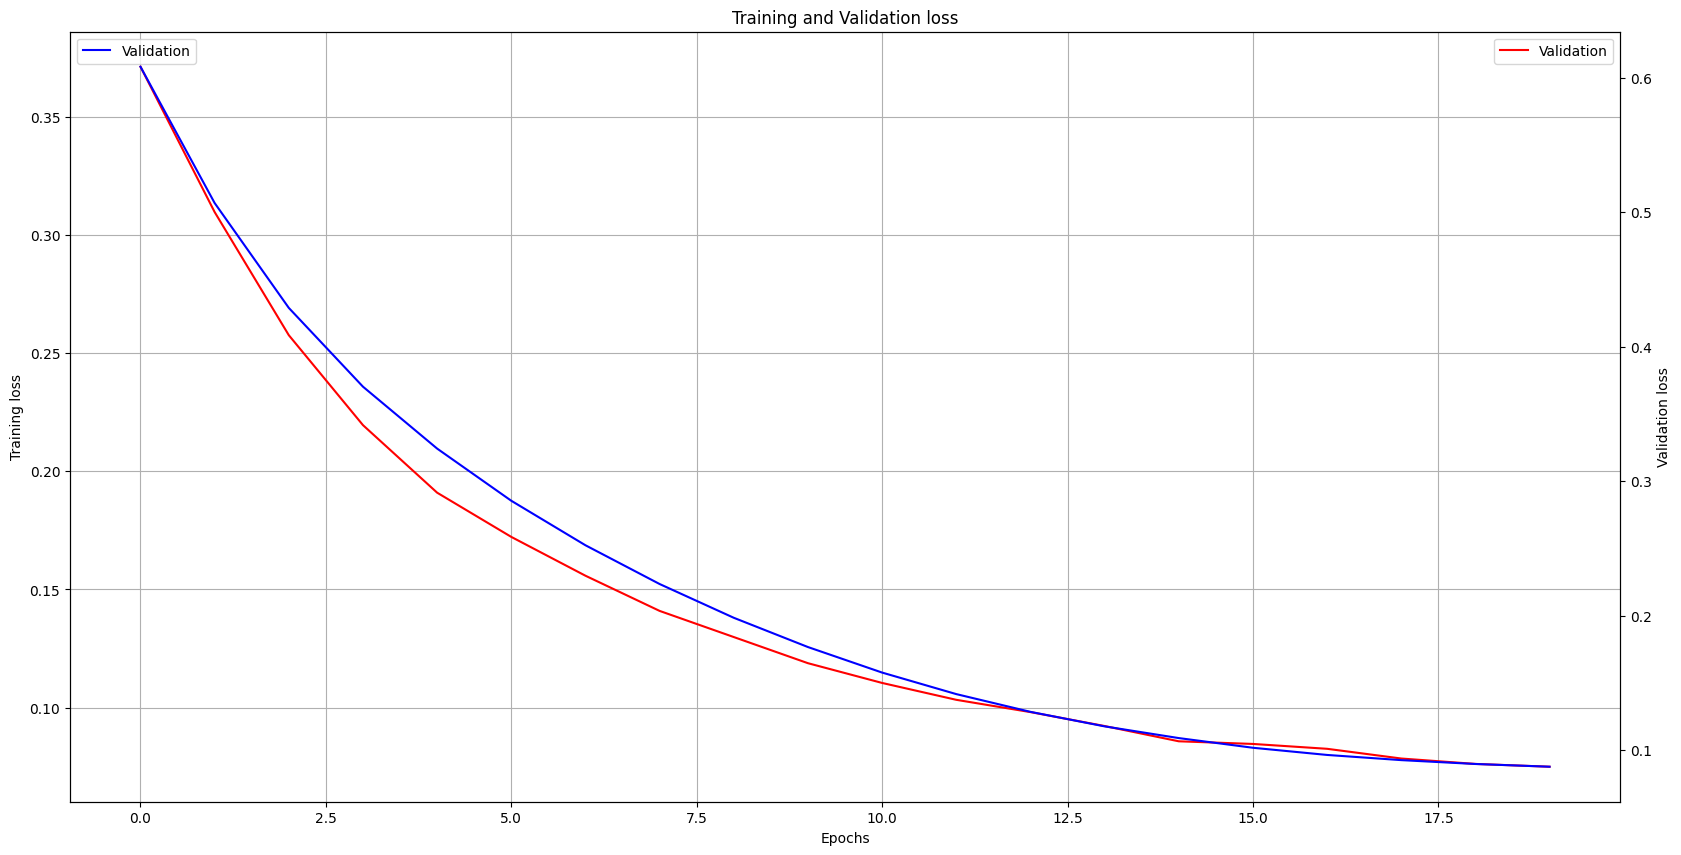

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(history.history["loss"], color="red", label="Validation")
axl = ax.twinx()
axl.plot(history.history["val_loss"], color="blue", label="Validation")
axl.set_ylabel("Validation loss")
axl.legend(loc="upper left")
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss")
ax.legend()
ax.grid()
ax.set_title("Training and Validation loss")

# Explore the predictions


In [118]:
Y_test_predicted_scaled = model.predict(X_test_scaled)
Y_test_predicted = Y_test_scaler.inverse_transform(Y_test_predicted_scaled)
Y_test_true = Y_test_scaler.inverse_transform(Y_test_scaled)

Y_train_predicted_scaled = model.predict(X_train_scaled)
Y_train_predicted = Y_train_scaler.inverse_transform(Y_train_predicted_scaled)
Y_train_true = Y_train_scaler.inverse_transform(Y_train_scaled)

27/27 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'On test set')

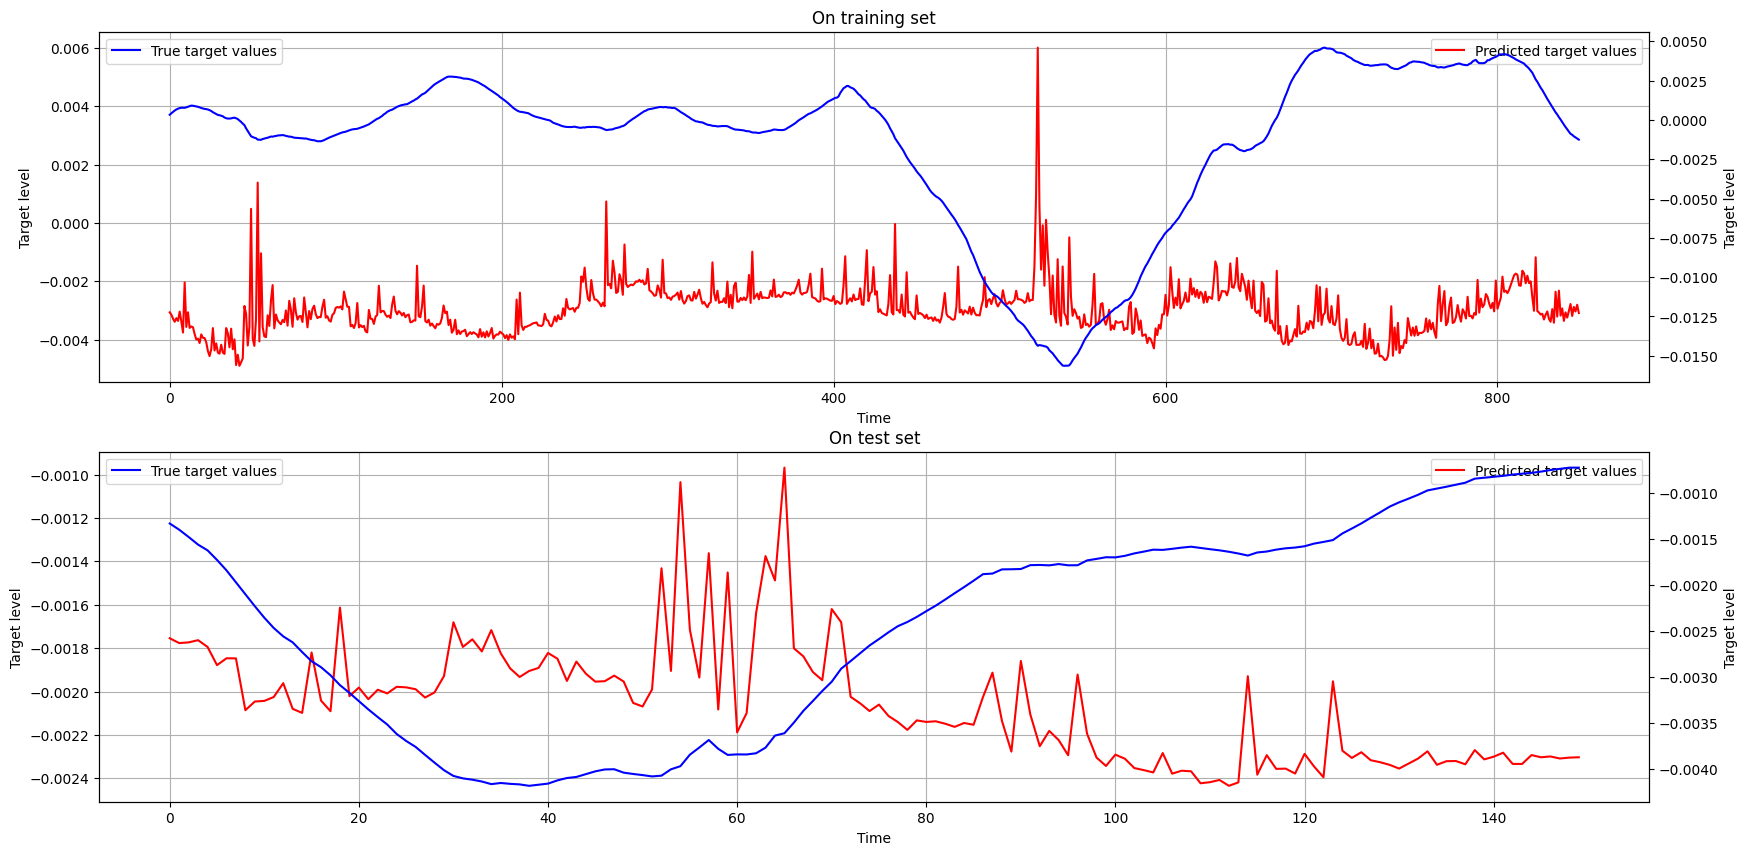

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(Y_train_predicted, color="red", label="Predicted target values")
axl = ax[0].twinx()
axl.plot(Y_train_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc="upper left")
ax[0].grid()
ax[0].set_title("On training set")

ax[1].plot(Y_test_predicted, color="red", label="Predicted target values")
axl = ax[1].twinx()
axl.plot(Y_test_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Target level")
ax[1].legend()
axl.legend(loc="upper left")
ax[1].grid()
ax[1].set_title("On test set")

Text(0.5, 1.0, 'On test set')

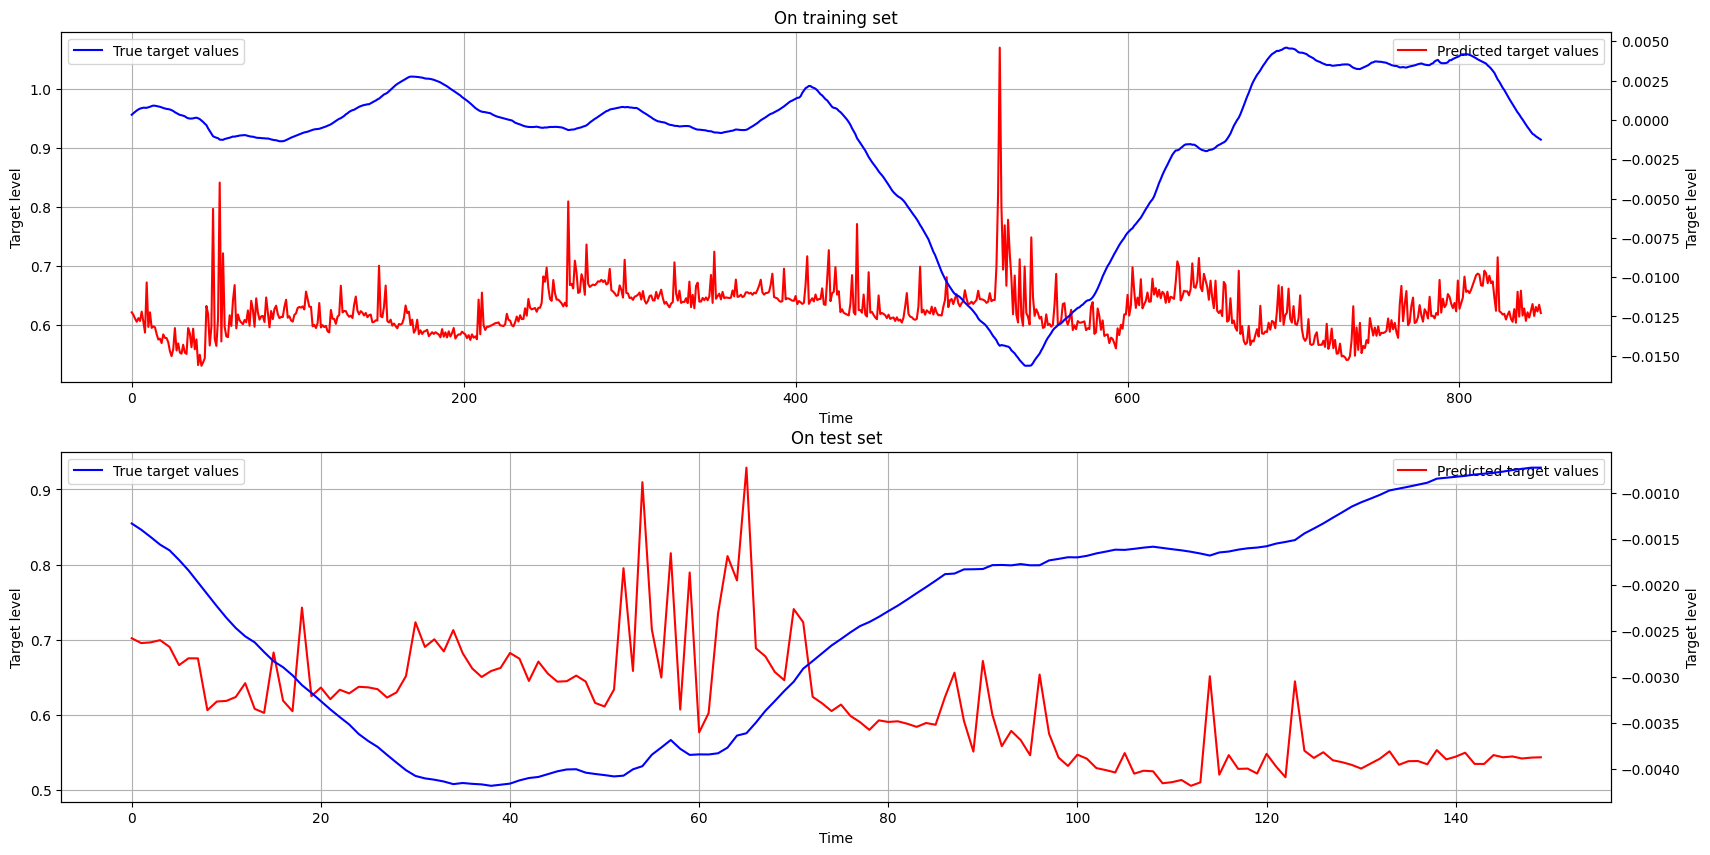

In [124]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(Y_train_predicted_scaled, color="red", label="Predicted target values")
axl = ax[0].twinx()
axl.plot(Y_train, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc="upper left")
ax[0].grid()
ax[0].set_title("On training set")

ax[1].plot(Y_test_predicted_scaled, color="red", label="Predicted target values")
axl = ax[1].twinx()
axl.plot(Y_test_true, color="blue", label="True target values")
axl.set_ylabel("Target level")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Target level")
ax[1].legend()
axl.legend(loc="upper left")
ax[1].grid()
ax[1].set_title("On test set")

# Apply Kalman Filter


In [12]:
df["signal"] = np.nan

# Backtesting the result


In [13]:

BUYING_THRESHOLD = 0.0001
for index, row in df.iterrows():

SyntaxError: incomplete input (91459824.py, line 2)